In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split  

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from datetime import datetime, date
import re


from sklearn.preprocessing import LabelEncoder


import math as math
from collections import Counter

from itertools import combinations

current_date = pd.to_datetime('17/03/2021')

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 200) # показывать больше колонок

df = pd.read_csv('main_task.csv',sep=",")


df.rename(columns = {
'Restaurant_id':'restaurant_id', 
'City':'city', 
'Cuisine Style':'cuisine_style',
'Ranking':'ranking',
'Rating':'rating',
'Price Range':'price_range',
'Number of Reviews':'reviews_number',
'Reviews':'reviews',
'URL_TA':'url_ta',
'ID_TA':'id_ta'}, inplace = True)

In [44]:
#Найдем столбцы с пустыми значениями
#df[df.columns[df.isna().any()]].isna().sum()
#df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]
df.columns[df.isna().any()].tolist()

['cuisine_style', 'price_range', 'reviews_number']

Заполним пропуски в price_range

In [45]:
df['price_range_is_nan'] = pd.isna(df['price_range']).astype('uint8')

# Заполним пропуски наиболее часто встречающимся значением в price_range
df['price_range'].fillna('$$ - $$$', inplace=True)

# Создадим справочник с диапазонами цен
price_range_dict = {'$': 10,'$$ - $$$': 100, '$$$$': 1000}

# Заменим на числовые значения
df['price_range'] = df['price_range'].map(price_range_dict)

Cоздадим новый признак cuisine_number, где пропущенные значения будут равны медиане(3) cuisine_style

In [46]:
# Значение 'cuisine_number' равно длине списка из столбца 'cuisine_style' или 3(медиана), если этот список пустой
df['cuisine_number']=df['cuisine_style'].apply(lambda x: 
                                                        len(str(x).replace("['", "").
                                                            replace("']", "").
                                                            replace("', '", ",").
                                                            split(',')) 
                                                        if str(x).replace("['", "").
                                                        replace("']", "").
                                                        replace("', '", ",").split(',')[0]!='nan' else 3)

# Вычислим среднее количество кухонь в ресторанах по городам
df['cuisine_count_mean'] = df['city'].map(df.groupby('city')['cuisine_number'].mean())

Для пустых reviews_number поставим 0, а для reviews пустой список

In [47]:
df['reviews_number_is_nan'] = pd.isna(df['reviews_number']).astype('uint8')

df['reviews_number'].fillna(0,inplace=True)

df['reviews'].fillna("[[], []]")

0        [['Good food at your doorstep', 'A good hotel ...
1        [['Unique cuisine', 'Delicious Nepalese food']...
2        [['Catch up with friends', 'Not exceptional'],...
3                                                 [[], []]
4        [['Best place to try a Bavarian food', 'Nice b...
5        [['There are better 3 star hotel bars', 'Amazi...
6        [['Excellent simple local eatery.', 'Excellent...
7        [['Wasting of money', 'excellent cuisine'], ['...
8                                                 [[], []]
9        [['Clean efficient staff', 'Nice little pizza ...
10                                                [[], []]
11       [['Not bad for Canary Wharf', 'To be a pilgrim...
12       [['Great service, good za', 'Lovely, relaxed a...
13       [['What a great spot!', 'Healthy superfoods, v...
14                                                [[], []]
15       [['Lovely food', 'Great coffee'], ['12/01/2017...
16       [['This is a real hidden Sushi-gem'], ['04/12/.

Обработка признаков



In [48]:
#Добавление относительного ранга ресторана по городам в зависимости от числа ресторанов в нем
#чем больше к единице, тем выше ранг ресторана
df['relative_ranking'] = 1-(df['ranking'] / df['city'].map(df.groupby(['city'])['ranking'].max()))

#Нормализуем количество отзывов  для каждого города
df['mean_number_of_reviews'] = df['reviews_number']/df['city'].map(df.groupby(['city'])['reviews_number'].max())

#Нормализуем диапазон цен для каждого города
df['mean_price_in_city'] = df['city'].map(df.groupby(['city'])['price_range'].mean())


# Создание признака "сетевой ресторан"
restaurant_chain = set()
for chain in df['restaurant_id']:
    restaurant_chain.update(chain)
def find_item(cell):
    if item in cell:
        return 1
    return 0
for item in restaurant_chain:
    df['restaurant_chain'] = df['restaurant_id'].apply(find_item)

In [49]:
# Создадим словарь, в котором ключами буду названия городов, а значениями 1, если этот город столица, в противном случае 0
city_capital = {'London': 1,'Paris': 1,'Madrid': 1,'Barcelona': 0,'Berlin': 1,
              'Milan': 0,'Rome': 1,'Prague': 1,'Lisbon': 1,'Vienna': 1,
              'Amsterdam': 1,'Brussels': 1,'Hamburg': 0,'Munich': 0,'Lyon': 0,
              'Stockholm': 1,'Budapest': 1,'Warsaw': 1,'Dublin': 1,'Copenhagen': 1,
              'Athens': 1,'Edinburgh': 1,'Zurich': 1,'Oporto': 0,'Geneva': 1,
              'Krakow': 1,'Oslo': 1,'Helsinki': 1,'Bratislava': 1,'Luxembourg': 1,'Ljubljana': 1}

# Создадим словарь с информацией о населении города
city_population = {'London': 8173900,'Paris': 2240621,'Madrid': 3155360,'Barcelona': 1593075,
                   'Berlin': 3326002,'Milan': 1331586,'Rome': 2870493,'Prague': 1272690,
                   'Lisbon': 547733,'Vienna': 1765649,'Amsterdam': 825080,'Brussels': 144784,
                   'Hamburg': 1718187,'Munich': 1364920,'Lyon': 496343,'Stockholm': 1981263,
                   'Budapest': 1744665,'Warsaw': 1720398,'Dublin': 506211 ,'Copenhagen': 1246611,
                   'Athens': 3168846,'Edinburgh': 476100,'Zurich': 402275,'Oporto': 221800,
                   'Geneva': 196150,'Krakow': 756183,'Oslo': 673469,'Helsinki': 574579,
                   'Bratislava': 413192,'Luxembourg': 576249,'Ljubljana': 277554}

In [50]:
# Создадим числовой признак, является ли город столицей
df['city_capital'] = df['city'].map(city_capital)

# Создадим словарь с данными о количестве ресторанов в каждом городе
restaurant_count = dict(df['city'].value_counts())
df['rest_count'] = df['city'].map(restaurant_count)

# Создадим признак с населением города
df['population'] = df['city'].map(city_population)

# Добавим числовой признак cколько человек в городе в среднем приходится на один ресторан
df['people_per_restaurant'] = df['population'] / df['rest_count']

# Добавим числовой признак cколько ресторанов на душу населения
df['restaurant_per_people'] = df['rest_count'] / df['population']

# Добавим числовой признак количество отзывов*100 на душу населения
df['reviews_per_people100'] = df.apply(lambda x:round(x['reviews_number']*10000/x['population'], 4), axis=1)

In [51]:
#Найдем дату отзыва
pattern = re.compile('\d+\W\d+\W\d+')

def reviews_dates(reviews):
    dates = []
    if type(reviews) is str:
        dates = pattern.findall(reviews)
    return dates

df['dates'] = df['reviews'].apply(reviews_dates)



# Количество дней между последними двумя отзывами ресторанов
def get_days_reviews(value):
    if type(value) is list:
        if len(value) == 2:
            return abs((pd.to_datetime(str(value[0]))-pd.to_datetime(str(value[1]))).days)
    return 0

df['days_between_reviews'] = df['dates'].apply(get_days_reviews)



# Вычтем из сегодняшней даты дату последнего отзыва
def get_days_today(value):
    if type(value) is list:
        if len(value) == 2:
            return abs((current_date - pd.to_datetime(str(value[0]))).days)
    return 7300

df['days_today'] = df['dates'].apply(get_days_today)

df = pd.get_dummies(df, columns=[ 'city',], dummy_na=True)

In [52]:
df.drop(['id_ta',], axis = 1, inplace=True) 

#df.drop(['days_between_reviews',], axis = 1, inplace=True)
#df.drop(['restaurant_per_people',], axis = 1, inplace=True)

#df.drop(['mean_number_of_reviews',], axis = 1, inplace=True)
#df.drop(['reviews_per_people100',], axis = 1, inplace=True)
#df.drop(['city_capital',], axis = 1, inplace=True)


#df.drop(['reviews_number',], axis = 1, inplace=True)
#df.drop(['days_today',], axis = 1, inplace=True)

#df.drop(['restaurant_chain',], axis = 1, inplace=True)
#df.drop(['price_range',], axis = 1, inplace=True)

#df.drop(['population',], axis = 1, inplace=True)

In [53]:
df.head()

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,price_range_is_nan,cuisine_number,cuisine_count_mean,reviews_number_is_nan,relative_ranking,mean_number_of_reviews,mean_price_in_city,restaurant_chain,city_capital,rest_count,population,people_per_restaurant,restaurant_per_people,reviews_per_people100,dates,days_between_reviews,days_today,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,id_5569,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,0,3,2.582806,0,0.601745,0.025453,133.099857,1,1,4897,2240621,457.549724,0.002186,0.8658,"[12/31/2017, 11/20/2017]",41,1172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1535,NaN,1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,1,3,3.126829,0,0.376218,0.006845,121.951220,1,1,820,1981263,2416.174390,0.000414,0.0505,"[07/06/2017, 06/19/2016]",382,1350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,0,7,3.302414,0,0.978533,0.071222,117.430954,1,1,5757,8173900,1419.819350,0.000704,0.8417,"[01/08/2018, 01/06/2018]",2,1164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,NaN,3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,1,3,2.961485,0,0.457313,0.001166,106.682135,1,1,2155,3326002,1543.388399,0.000648,0.0090,[],0,7300,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,0,3,3.033595,0,0.775244,0.017895,132.150056,1,0,893,1364920,1528.465845,0.000654,0.6154,"[11/18/2017, 02/19/2017]",272,1215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [54]:
# Используем разные комбинации

def numeric_interaction_terms(df, columns):
    fe_df = pd.DataFrame()
    for c in combinations(columns,2):
        fe_df['{} * {}'.format(c[0], c[1]) ] = df1[c[0]] * df1[c[1]]
    return fe_df

to_interact_cols = [         
        'cuisine_count_mean', 
        'mean_price_in_city',
        'days_between_reviews',
        'days_today',
        'rest_count',
        'reviews_per_people100',
        'city_Rome',
        'mean_number_of_reviews',
        'relative_ranking'        
    ]

In [55]:
df.head()

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,price_range_is_nan,cuisine_number,cuisine_count_mean,reviews_number_is_nan,relative_ranking,mean_number_of_reviews,mean_price_in_city,restaurant_chain,city_capital,rest_count,population,people_per_restaurant,restaurant_per_people,reviews_per_people100,dates,days_between_reviews,days_today,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,id_5569,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,0,3,2.582806,0,0.601745,0.025453,133.099857,1,1,4897,2240621,457.549724,0.002186,0.8658,"[12/31/2017, 11/20/2017]",41,1172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1535,NaN,1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,1,3,3.126829,0,0.376218,0.006845,121.951220,1,1,820,1981263,2416.174390,0.000414,0.0505,"[07/06/2017, 06/19/2016]",382,1350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,0,7,3.302414,0,0.978533,0.071222,117.430954,1,1,5757,8173900,1419.819350,0.000704,0.8417,"[01/08/2018, 01/06/2018]",2,1164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,NaN,3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,1,3,2.961485,0,0.457313,0.001166,106.682135,1,1,2155,3326002,1543.388399,0.000648,0.0090,[],0,7300,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,0,3,3.033595,0,0.775244,0.017895,132.150056,1,0,893,1364920,1528.465845,0.000654,0.6154,"[11/18/2017, 02/19/2017]",272,1215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [56]:
#Удалим все нечисловые признаки
df1 = pd.DataFrame
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df1 = df.drop(object_columns, axis = 1)

df2 = pd.DataFrame
df_fe = numeric_interaction_terms(df,to_interact_cols)
df2 = pd.concat([df1, df_fe], axis=1)

In [57]:
new_corr = df2.corr()
new_corr['rating'].sort_values(ascending=False)

rating                                           1.000000
relative_ranking                                 0.544573
cuisine_count_mean * relative_ranking            0.540232
mean_price_in_city * relative_ranking            0.523422
days_today * relative_ranking                    0.435823
rest_count * relative_ranking                    0.277076
cuisine_number                                   0.117340
days_between_reviews * relative_ranking          0.101520
days_today * city_Rome                           0.098281
cuisine_count_mean                               0.084211
cuisine_count_mean * city_Rome                   0.083082
city_Rome                                        0.083082
rest_count * city_Rome                           0.083082
mean_price_in_city * city_Rome                   0.083082
mean_number_of_reviews * relative_ranking        0.077072
city_Rome * relative_ranking                     0.068690
people_per_restaurant                            0.060405
reviews_per_pe



РАЗДЕЛЕНИЕ ДАТАФРЕЙМА

In [58]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df2.drop(['rating'], axis = 1)  
y = df2['rating']
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



СОЗДАНИЕ, ОБУЧЕНИЕ И ТЕСТИРОВАНИЕ МОДЕЛИ

In [59]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [60]:
# Округляем полученные значения рейтингов
def round_d(rec):
    if rec <0.25:
        return 0
    elif 0.25<rec<=0.75:
        return 0.5
    elif 0.75<rec<=1.25:
        return 1
    elif 1.25<rec<=1.75:
        return 1.5
    elif 1.75<rec<=2.25:
        return 2
    elif 2.25<rec<=2.75:
        return 2.5
    elif 2.75<rec<=3.25:
        return 3
    elif 3.25<rec<=3.75:
        return 3.5
    elif 3.75<rec<=4.25:
        return 4
    elif 4.25<rec<=4.75:
        return 4.5
    else:
        return 5
    
for i in range(y_pred.size):
    y_pred[i]=round_d(y_pred[i])

In [61]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.17275


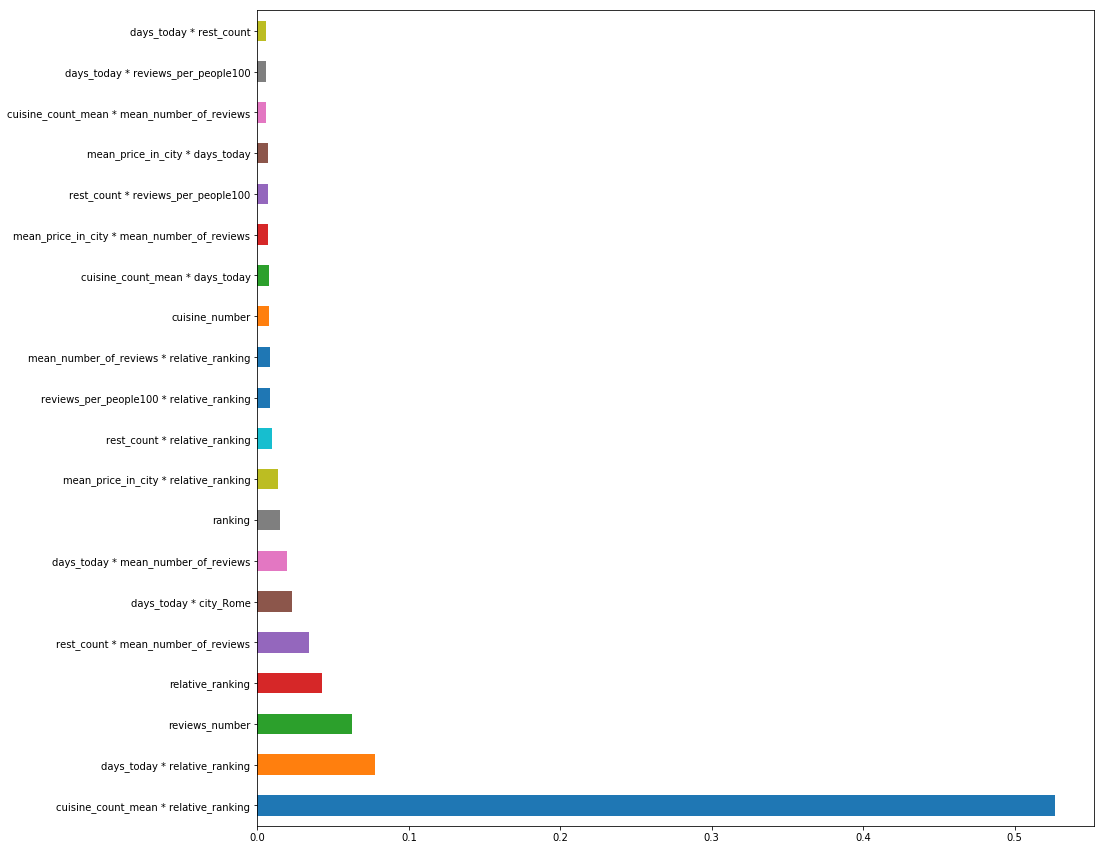

In [62]:
# Отобразим топ 20 наиболее важных признаков для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')